In [31]:
import numpy as np
import pandas as pd
import datetime
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import matplotlib.pyplot as plt
%matplotlib inline
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
items_categories = pd.read_csv('item_categories.csv')
submission = pd.read_csv('sample_submission.csv')

In [32]:
def preprocess_date(data):
    data.date = data.date.apply(lambda x : datetime.datetime.strptime(x, '%d.%m.%Y'))
    return data

# test if functions work
train = preprocess_date(train)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [33]:
def groupby_dbn_shopid_item(data):
    month_sales = data.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min","max"], "item_price":"mean", "item_cnt_day":"sum"})
    return month_sales

def create_timeseries(data):
    ts = data.groupby(["date_block_num"])["item_cnt_day"].sum()
    ts.astype('float')
    return ts

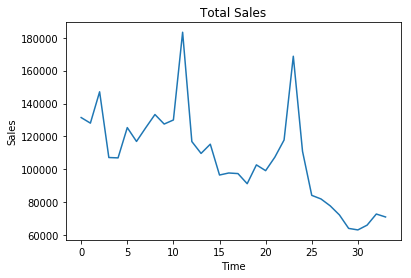

In [44]:
ts = create_timeseries(train)
plt.title("Total Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(ts)
plt.show()

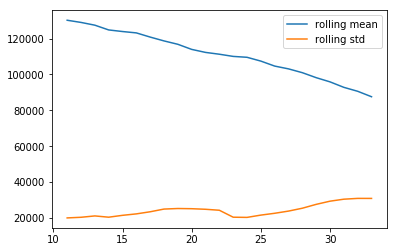

In [45]:
plt.plot(ts.rolling(window=12,center=False).mean(), label="rolling mean")
plt.plot(ts.rolling(window=12,center=False).std(), label="rolling std")
plt.legend()
plt.show()

In [25]:
# test stationarity 
def test_stationarity(ts):
    adf = adfuller(ts, autolag = "AIC")
    adfoutput = pd.Series(adf[0:4], index = ["Test Statistic", "p-value", "# of lags used", "Number of Obversation"])
    for key, value in adf[4].items():
        adfoutput["critical value (" + key + ")"] = value
    print(adfoutput)
test_stationarity(ts)

Test Statistic           -2.395704
p-value                   0.142953
# of lags used            0.000000
Number of Obversation    33.000000
critical value (1%)      -3.646135
critical value (5%)      -2.954127
critical value (10%)     -2.615968
dtype: float64


In [43]:
# Create differenced series
def difference(data, interval = 1):
    diff = []
    for i in range(interval, len(data)):
        val = data[i] - data[i - interval]
        diff.append(val)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, val):
    return val + last_ob

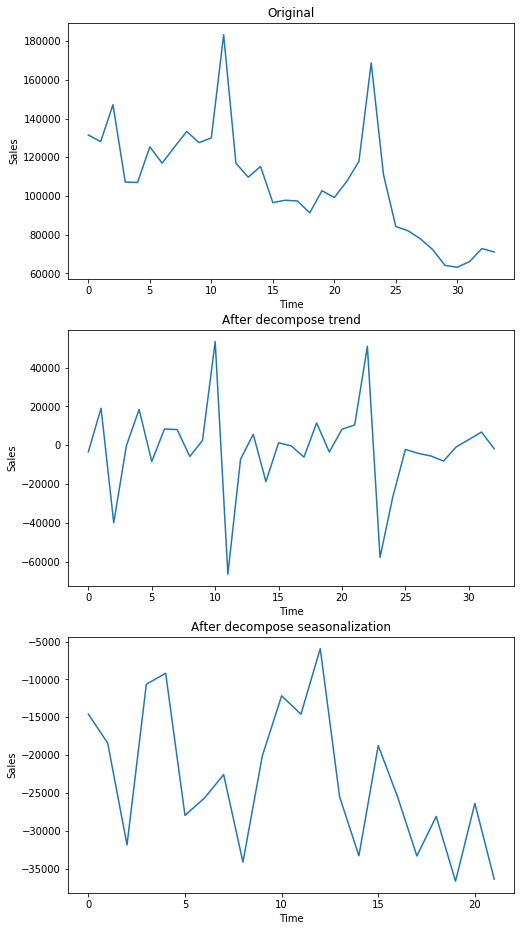

In [53]:
ts = create_timeseries(train)
plt.figure(figsize=(8, 16))
plt.subplot(311)
plt.title("Original")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.plot(ts)

plt.subplot(312)
plt.title("After decompose trend")
plt.xlabel("Time")
plt.ylabel("Sales")
detrend_ts = difference(ts)
plt.plot(detrend_ts)
plt.plot()

plt.subplot(313)
plt.title("After decompose seasonalization")
plt.xlabel("Time")
plt.ylabel("Sales")
deseason_ts = difference(ts, 12)
plt.plot(deseason_ts)
plt.plot()
plt.show()

In [54]:
test_stationarity(deseason_ts)

Test Statistic           -3.270101
p-value                   0.016269
# of lags used            0.000000
Number of Obversation    21.000000
critical value (1%)      -3.788386
critical value (5%)      -3.013098
critical value (10%)     -2.646397
dtype: float64


5
